# Time Series vs Regression - A Simple Case Study
# (Melbourne Temperature Data)

## Overview

Depending on which forum you read and the background of the individual you're asking, either A) ML frameworks are clearly inferior for time-series datasets, or B) (S)ARIMA(X) models are just old-school and you should try something like gradient boosting! Coming from an ML background and being frustrated at my naivety on ARIMA-like models, I felt the need to put this to the test with a quick case study.

In order to do so, I run a quick analysis using both a linear regression model (from SciKitLearn) and a SARIMA model (from StatsModels) on the same dataset -- "Daily Minimum Temperatures in Melbourne Australia" (previously available from the [Time Series Data Library](https://robjhyndman.com/hyndsight/tsdl/) (citing: Australian Bureau of Meteorology), now availabe on multiple Kaggle sites). The data is aggregated up to the monthly level just to make it a cleaner project with clear seasonality (and faster for my computer!).

The argument is not to find the "best" regression or SARIMA model, but to give each a fair shake. More complex datasets undoubtedly would yield different results, but this is a simple learning experience to ball-park the key ideas.

Our end goal will be to predict a 1-step-ahead temperature value (so the next month's avg minimum temperature). We'll evaluate the model's by their RMSE.

## Table of Contents

* [Notebook Setup](#Notebook_Setup)
* [Data Import and Setup](#Data_Import_and_Setup)
* [ML Framework](#ML_Framework)
  * [Autocorrelation](#Autocorrelation)
  * [Seaonality & Trend](#ML_Seasonality_and_Trend)
  * [Other Feature Engineering](#ML_Other_Feature_Engineering)
  * [Train Test Setup](#ML_Train_Test_Setup)
  * [Regression Model Selection](#ML_Regression_Model_Selection)
  * [Test Set Evaluation](#ML_Test_Set_Evaluation)
* [Time-Series Framework](#Time-Series_Framework)
 * [SARIMA Model Selection](#T_Sarima_Model_Selection)
 * [Test Set Evaluation](#T_Test_Set_Evaluation)
* [Conclusion](#Conclusion)

## Notebook Setup
<a id='Notebook_Setup'></a>

In [593]:
# Data packages
import numpy as np
import pandas as pd

# Plotting packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
sb.set()

# Time-series specific packages
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

# ML-related model package
from sklearn.linear_model import Ridge

# Statsmodels package which contains SARIMA
import statsmodels.api as sm

# Other misc packages
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy.polynomial.polynomial as poly
from scipy.stats import skew
from tqdm import tqdm
from warnings import catch_warnings
from warnings import filterwarnings

## Data Import and Setup
<a id='Data_Import_and_Setup'></a>

There are a few question marks you might find in the data depending on where you download that were cleaned before load for simplicity. We're expecting a daily date column called "Date." In general, we expect the data fairly clean enough to not have to interrogate it for bugs.

In [594]:
# Import the data into a dataframe
df = pd.read_csv('daily-minimum-temperatures.csv', parse_dates=['Date'])
df.head()

,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [595]:
# Double check the structure
df.columns = ['Date', 'Temp']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


In [596]:
# Double check for reasonable values
df.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


The data used here is aggregated up to the monthly level to make the project a little bit cleaner.

In [597]:
# Set the date as the index
df.set_index('Date', inplace=True)

# Use pandas to resample to monthly based on the index
df = df.resample('M').mean()

# Pull the index back out
df.reset_index(inplace=True)
df.sort_values(by='Date', ascending=True) # Just in case not already and for convenience
df.head()

,Date,Temp
0,1981-01-31,17.712903
1,1981-02-28,17.678571
2,1981-03-31,13.500000
3,1981-04-30,12.356667
4,1981-05-31,9.490323


Now let's visually inspect the data to get a feel for it.

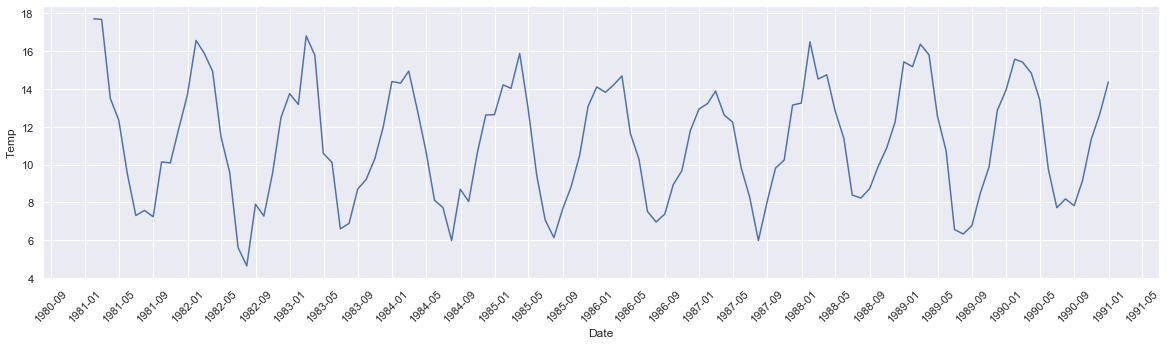

In [598]:
# Plot the data in clean, monthly increments
fig, ax = plt.subplots(figsize=(20, 5))
g = sb.lineplot(data=df, x='Date', y='Temp', ax=ax)
plt.xticks(rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

This data should be nice to play with. The seasonality here is quite clear while still retaining some local structure that hopefully we can pick up in modelling.

In order to really give each model a fair comparison, we should isolate a test set to compare against while only making model inferences on the train set.

In [599]:
# Logic for defining our train set
df_train = df[df.Date < '1988-06-30']

To get a visual feel for the division, let's plot the data again with a red line separating our train/test cutoff. The cutoff here is fairly arbitrary but gives us enough seasonal cycling to try and predict on both the train and test side.

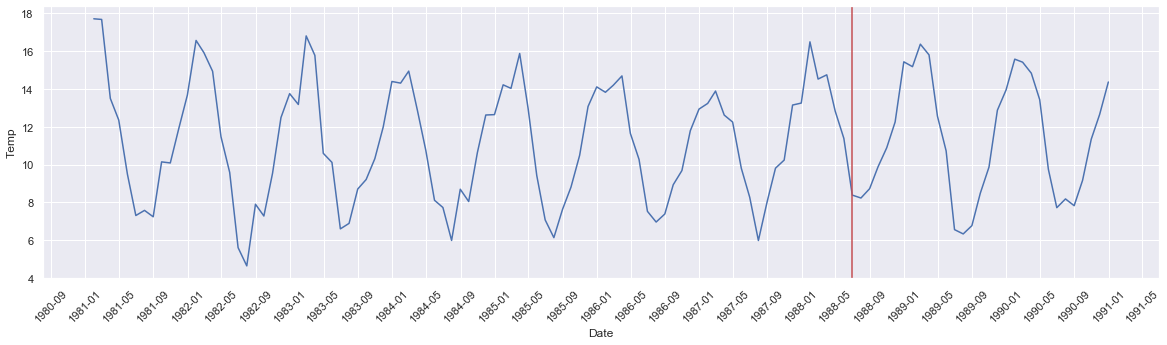

In [600]:
# Plot the data again with the train/test cutoff line
fig, ax = plt.subplots(figsize=(20, 5))
g = sb.lineplot(data=df, x='Date', y='Temp', ax=ax)
plt.xticks(rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.axvline(dt.datetime(1988, 6, 30), color='r')

plt.show()

## ML Framework
<a id='ML_Framework'></a>

From my personal bias, coming from a machine learning based framework offers a lot of convenience. For me, it's what I'm already more familiar with, but it also provides the options like using exogenous variables (though a SARIMA(X) approach could also achieve this), a lot of flexibility in the input, a host of algorithms (XGBoost, LSTMs, some nice libraries), and some well-optimized processes.

In this case we'll take a simple approach and use linear regression with L2 penalties (so Ridge regression). Our general strategy will be to build up new features off of an otherwise univariate dataset so as to model out the time-dependant elements of the series.

### Autocorrelation
<a id='ML_Autocorrelation'></a>

We can start with the obvious -- autocorrelation. Conveniently Pandas provides a simple means of representing this from its own plotting library.

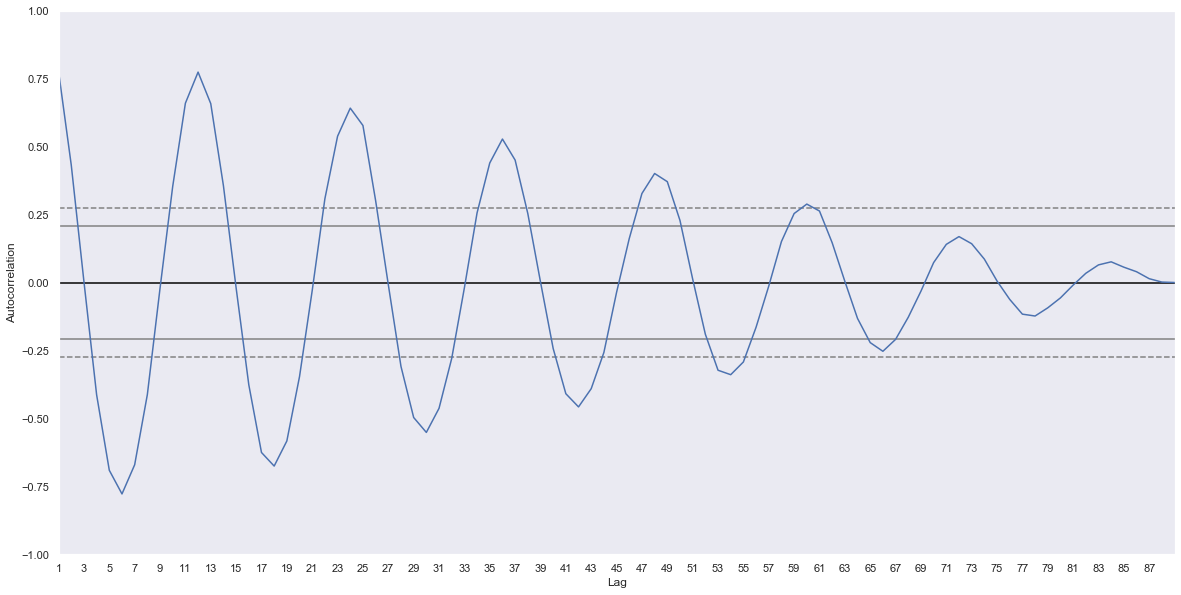

In [601]:
# Plot the autocorrelations of the series
plt.figure(figsize=(20, 10))
pd.plotting.autocorrelation_plot(df_train.Temp) # Use just the training data so that we're not peaking
plt.xticks(np.arange(1, len(df_train), 2))
plt.show()

The seasonality of the dataset immediately jumps out here, but it's also clear that we might possibly have some strong autocorerlations for up to 12 lags (or 1 year), after which the pattern gradually subsides. We could go farther than a year, but that would then cause us to lose some training records for earlier values. We could also try differencing against the monthly seasonality before running this to really pick out the best lags, but we'll take a naive approach and let regularization do some of the hard work for us.

Let's set up those lag features in the data. Let's also go ahead and set up the target feature while we're at it.

In [602]:
# Create an empty dict for the lag values
lag_cols = {}

# Grab the series for each lag to store in the dict
for lag in range(12):
    col_name = 'TempLag{}'.format(lag + 1)
    lag_cols[col_name] = df.Temp.shift(lag + 1)

# Create a df for the lag columns and the target column
lag_data = pd.DataFrame(data=lag_cols)
target_data = pd.DataFrame(data={'NextTemp': df.Temp.shift(-1)})

# Concat all our data together and check the result
df = pd.concat([df, target_data, lag_data], axis=1)
df.head()

,Date,Temp,NextTemp,TempLag1,TempLag2,TempLag3,TempLag4,TempLag5,TempLag6,TempLag7,TempLag8,TempLag9,TempLag10,TempLag11,TempLag12
0,1981-01-31,17.712903,17.678571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1981-02-28,17.678571,13.500000,17.712903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1981-03-31,13.500000,12.356667,17.678571,17.712903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1981-04-30,12.356667,9.490323,13.500000,17.678571,17.712903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1981-05-31,9.490323,7.306667,12.356667,13.500000,17.678571,17.712903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Seasonality & Trend
<a id='ML_Seasonality_and_Trend'></a>

Other key aspects of a time-series model include seasonality and trend, of which, we at least know some seasonality is present and needs be accounted for. Statsmodels conviently has two naive methods to tease these apart from our time-series -- `seasonal_decompose` and `STL`. Each, through different means (see their docs for more info), will produce a plot of the season and trend components of the series (along with the remaining residuals).

Let's run both of them.

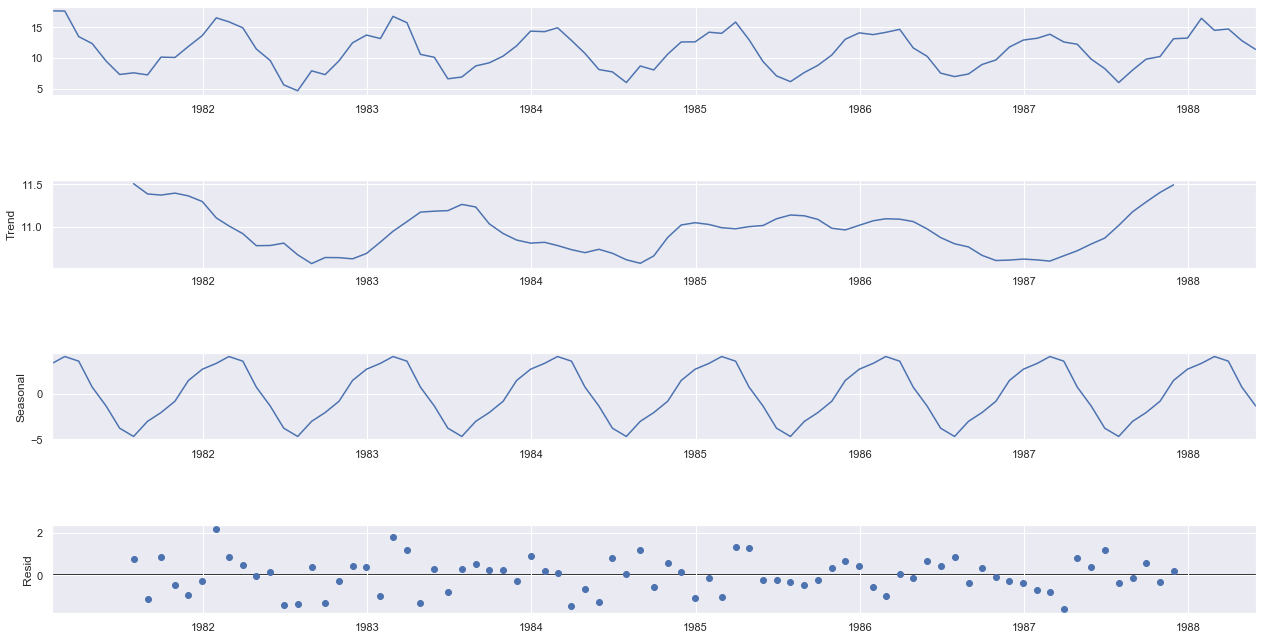

In [603]:
# Statsmodels seasonal_decompose method
decomped = seasonal_decompose(df_train.set_index('Date'), model='additive')
fig = decomped.plot()
fig.set_size_inches(20, 10)
plt.show()

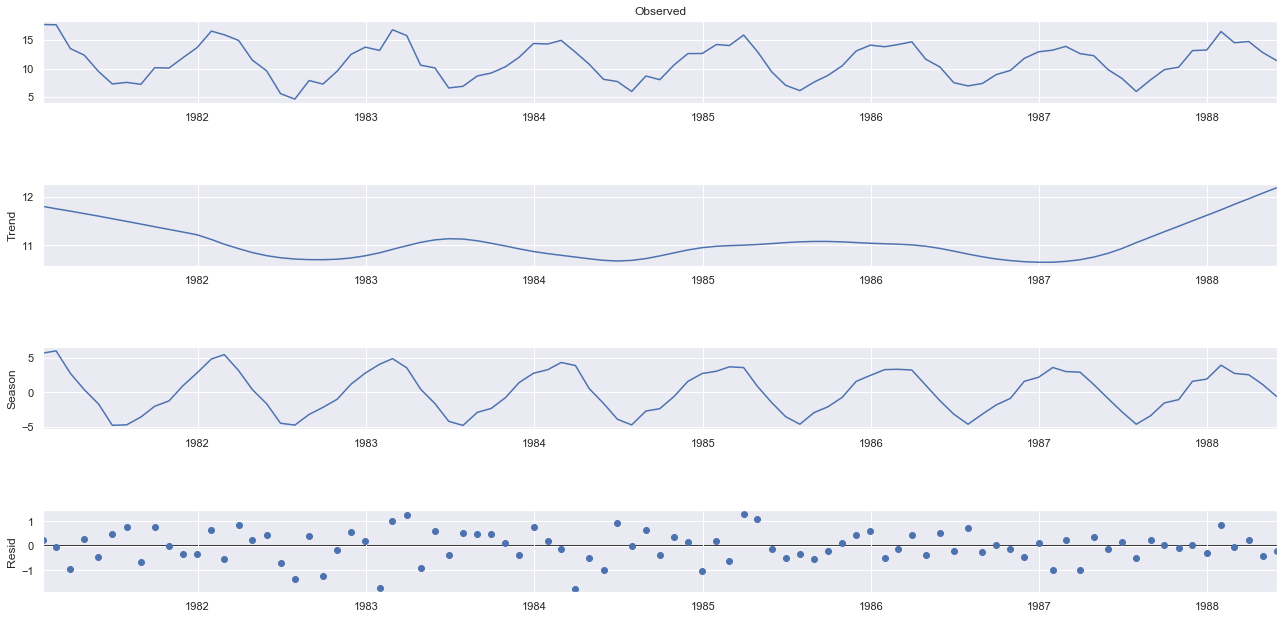

In [604]:
# Statsmodels STL method
decomped = STL(df_train.set_index('Date')).fit()
fig = decomped.plot()
fig.set_size_inches(20, 10)
plt.show()

Both decomposition plots show a clear, yearly seasonality by month just as one might expect. There also appears to *possibly* be a sort of remainder "meta" seasonality leftover in the trend series stretching across every few years. To the extend that any long-term trend exists, the cycle seems to extend beyond the window of our training data and not likely consistent enough to model. We'll focus our efforts on the seasonality instead.

One naive way to do that would be to simply one-hot encode the months themselves.

In [605]:
# OH Encode the months
months = df.Date.dt.month_name()
df =  df.join(pd.get_dummies(months))
df.head()

,Date,Temp,NextTemp,TempLag1,TempLag2,TempLag3,TempLag4,TempLag5,TempLag6,TempLag7,...,December,February,January,July,June,March,May,November,October,September
0,1981-01-31,17.712903,17.678571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
1,1981-02-28,17.678571,13.500000,17.712903,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
2,1981-03-31,13.500000,12.356667,17.678571,17.712903,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
3,1981-04-30,12.356667,9.490323,13.500000,17.678571,17.712903,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1981-05-31,9.490323,7.306667,12.356667,13.500000,17.678571,17.712903,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0


A more sophisticed way would be to fit a simple polynomial function to the observed seasonality. That is, using only the index from the month data itself, can we try to fit the general cyclic pattern. To do so, let's first generate that index.

In [606]:
# Simple seasonal index for the data
df['SeasonalIndex'] = df.Date.dt.month

Let's refresh our training set so we also have this feature there.

In [607]:
# Refresh the training dataset
df_train = df[df.Date < '1988-06-30']

We can treat this like a min-ML problem by defining our input (x) and target (y).

In [608]:
# Define our x and y values
x = df_train.SeasonalIndex.values
y = df_train.Temp.values

Numpy has a handy method `polyfit()` that will fit a simple polynomial equation given your x values, y values, and a specific degree of the polynomial. Through some trial and error below we can arrive at a degree of 4 as a reasonable fit.

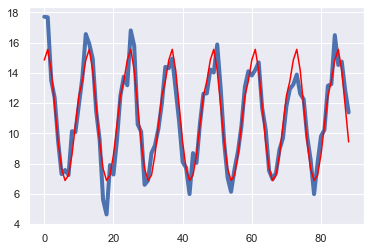

In [609]:
# Fit the coefficients of the polynomial function
coeffs = poly.polyfit(x, y, 4)

# Grab the resultant values (y-hats) of the function when applying the "model"
fitvals = poly.polyval(x, coeffs)

# Plot the results
plt.plot(y, linewidth=4)
plt.plot(fitvals, color='red')
plt.show()

Impressively, we can grab a lot of the variance from this series *just* using the month fit to a polynomial. We definitely should include this in our dataset.

In [610]:
# Add the seasonal column which represents the polynomial fit of the month index
df['Seasonal'] = poly.polyval(df.SeasonalIndex.values, coeffs)
df.head()

,Date,Temp,NextTemp,TempLag1,TempLag2,TempLag3,TempLag4,TempLag5,TempLag6,TempLag7,...,January,July,June,March,May,November,October,September,SeasonalIndex,Seasonal
0,1981-01-31,17.712903,17.678571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,1,14.850554
1,1981-02-28,17.678571,13.500000,17.712903,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,2,15.557219
2,1981-03-31,13.500000,12.356667,17.678571,17.712903,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,3,14.157922
3,1981-04-30,12.356667,9.490323,13.500000,17.678571,17.712903,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,4,11.815629
4,1981-05-31,9.490323,7.306667,12.356667,13.500000,17.678571,17.712903,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,5,9.435058


Now let's see if there's any apparent trend leftover after de-seasoning the data.

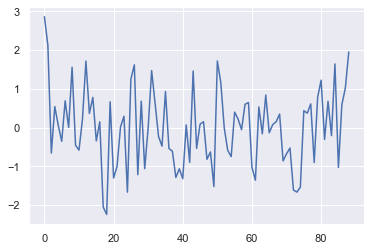

In [611]:
# Update the training dataset
df_train = df[df.Date < '1988-06-30']

# Plot the "de-seasoned" time-series
plt.plot(df_train.Temp - df_train.Seasonal)
plt.show()

Looking at the de-seasoned data, it doesn't appear that there is much of a trend leftover as was our initial take. Let's do one more thing to make this easier for our regression model to read.

We are predicting the next temperature value, so obviously we can't use our "NextTemp" column as part of the prediction, *but* we actually have everything we need for a "Next Seasonal" value. We (at the time of a prediction) know the upcoming seasonal index (this month's + 1) and our polynomial function is already known and static.

Given this, let's use the "next" Seasonal value as input for the next temperature value. We'll then drop the current Seasonal value which, after all, should just be a value close to the current temperature.

In [612]:
# Create the next seasonal value
df['SeasonalIndexNext'] = df.SeasonalIndex.apply(lambda x: x + 1 if x < 12 else 1)
df['SeasonalNext'] = poly.polyval(df.SeasonalIndexNext, coeffs)

# Get rid of uneeded columns
df.drop(columns=['SeasonalIndex', 'SeasonalIndexNext', 'Seasonal'], inplace=True)

# Update the training dataset
df_train = df[df.Date < '1988-06-30']

# Check the results across a whole season
df.head(12)

,Date,Temp,NextTemp,TempLag1,TempLag2,TempLag3,TempLag4,TempLag5,TempLag6,TempLag7,...,February,January,July,June,March,May,November,October,September,SeasonalNext
0,1981-01-31,17.712903,17.678571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,15.557219
1,1981-02-28,17.678571,13.500000,17.712903,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,14.157922
2,1981-03-31,13.500000,12.356667,17.678571,17.712903,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,11.815629
3,1981-04-30,12.356667,9.490323,13.500000,17.678571,17.712903,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,9.435058
4,1981-05-31,9.490323,7.306667,12.356667,13.500000,17.678571,17.712903,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,7.662683
5,1981-06-30,7.306667,7.577419,9.490323,12.356667,13.500000,17.678571,17.712903,NaN,NaN,...,0,0,0,1,0,0,0,0,0,6.886731
6,1981-07-31,7.577419,7.238710,7.306667,9.490323,12.356667,13.500000,17.678571,17.712903,NaN,...,0,0,1,0,0,0,0,0,0,7.237183
7,1981-08-31,7.238710,10.143333,7.577419,7.306667,9.490323,12.356667,13.500000,17.678571,17.712903,...,0,0,0,0,0,0,0,0,0,8.585773
8,1981-09-30,10.143333,10.087097,7.238710,7.577419,7.306667,9.490323,12.356667,13.500000,17.678571,...,0,0,0,0,0,0,0,0,1,10.545989
9,1981-10-31,10.087097,11.890000,10.143333,7.238710,7.577419,7.306667,9.490323,12.356667,13.500000,...,0,0,0,0,0,0,0,1,0,12.473073


### Other Feature Engineering
<a id='ML_Other_Feature_Engineering'></a>

What we have so far is likely enough to run a model, but there might be some other interesting features we could create.

For one, rather than using the values of the prior lags themselves, we could use the difference between the current value and those lags.

In [613]:
# Create a list of the lag columns using the previously made dict
lag_list = list(lag_cols.keys())

# Create our new differenced ("Delta") columns via subtraction
for col in lag_list:
    df['Delta{}'.format(col)] = df['Temp'] - df['{}'.format(col)]

# Sample a record 1 year in to double check the results
df.iloc[12, :]

Date              1982-01-31 00:00:00
Temp                          16.5677
NextTemp                      15.9214
TempLag1                      13.6806
TempLag2                        11.89
TempLag3                      10.0871
TempLag4                      10.1433
TempLag5                      7.23871
TempLag6                      7.57742
TempLag7                      7.30667
TempLag8                      9.49032
TempLag9                      12.3567
TempLag10                        13.5
TempLag11                     17.6786
TempLag12                     17.7129
April                               0
August                              0
December                            0
February                            0
January                             1
July                                0
June                                0
March                               0
May                                 0
November                            0
October                             0
September   

Another thing we could do is check for the skewness of the previous lags. If a given lag set is skewing more to the left or right than that of previous records, this may give us a clue to how quickly the temperature is accelerating/decelerating.

As an arbitary hunch, we'll just grab the last few lags for our skew. One might experiment to different effect.

In [614]:
# Create our skew column based on the lagged temp values
skew_cols = ['TempLag{}'.format(lag + 1) for lag in range(3)] + ['Temp']
df['TempSkew'] = skew(df[skew_cols], axis=1)

# Sample a record 1 year in to double check the results
df.iloc[12, :]

Date              1982-01-31 00:00:00
Temp                          16.5677
NextTemp                      15.9214
TempLag1                      13.6806
TempLag2                        11.89
TempLag3                      10.0871
TempLag4                      10.1433
TempLag5                      7.23871
TempLag6                      7.57742
TempLag7                      7.30667
TempLag8                      9.49032
TempLag9                      12.3567
TempLag10                        13.5
TempLag11                     17.6786
TempLag12                     17.7129
April                               0
August                              0
December                            0
February                            0
January                             1
July                                0
June                                0
March                               0
May                                 0
November                            0
October                             0
September   

Finally, another idea is to model the next temp off of the moving average of the temperature rather than the current temp. This would be particularly useful for noisy data (which isn't as much the case here), but is worth a try.

In [615]:
# Create a column for the moving average of the last half-year's worth of lagged temps
moving_avg_cols = ['TempLag{}'.format(lag + 1) for lag in range(5)] + ['Temp']
df['SixMonthMovingAvg'] = np.mean(df[moving_avg_cols], axis=1)

There is likely much more that could be done (for instance capturing data like the high and low for the season, etc etc), but this seems a fair place to stop and gives our regression model a good bit to play with.

### Train Test Setup
<a id='ML_Train_Test_Setup'></a>

With our features ready, we can set up our train and test sets. For the train set, we know our lags will cause some missing values in the earlier data, so let's go ahead and drop those. We'll also have on record at the end for which we won't yet know the actual in the test set (so drop that also).

In [616]:
# Create our train and test sets
df_train = df[df.Date < '1988-06-30'].copy()
df_train.dropna(inplace=True)
df_test = df[df.Date >= '1988-06-30'].copy()
df_test.dropna(inplace=True)

Since we want a parsimonious model, it's advantageous to try multiple feature subsets. We'll set that up below usings some of my own personal intituions. We'll also go ahead and define our X and y for SciKitLearn training and test inputs.

In [617]:
# Create some convenient column lists
month_cols = list(df.Date.dt.month_name().unique())
delta_cols = ['Delta{}'.format(col) for col in lag_list]

# Define our X and y for the test set
y_test = df_test.NextTemp
Xall_test = df_test.drop(columns=['Date', 'NextTemp'])

# Define our Xs and y for the train set
y_train = df_train.NextTemp
# Multiple different X possibilities based on my intuition
Xall_train = df_train.drop(columns=['Date', 'NextTemp'])
Xb_train = df_train.drop(columns=['Date', 'NextTemp'] + lag_list + month_cols)
Xc_train = df_train.drop(columns=['Date', 'NextTemp'] + lag_list + month_cols + ['SixMonthMovingAvg'])
Xd_train = df_train.drop(columns=['Date', 'NextTemp'] + lag_list + month_cols + ['Temp'])
Xe_train = df_train.drop(columns=['Date', 'NextTemp'] + delta_cols + ['SeasonalNext'])

# Finally we'll create a dict of X_trains so we can iterate over that
train_dict = {'Xall_train':Xall_train, 'Xb_train':Xb_train, 'Xc_train':Xc_train, 'Xd_train':Xd_train, 'Xe_train':Xe_train}

### Regression Model Selection
<a id='ML_Regression_Model_Selection'></a>

We use Ridge regression in this case as an attempt to help force a more parsimonious model. As such we'll want to do a hyperparemter search on the alpha values. Below we set up a convenience function for that.

In [618]:
def ridge_hyper_search(X=None, alphas=None, verbosity=2):

    # Create a grid of parameters to search through
    param_dist = {'alpha':alphas}
    
    # Initialize the model
    regressor = Ridge()

    # Initialize the time series cv setup
    series_cv = TimeSeriesSplit(n_splits=5).split(X)
    
    # Initialize the gridsearch classifier
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_dist,
                               cv=series_cv, scoring='neg_root_mean_squared_error',
                               refit=True, verbose=verbosity)
    
    # Run the grid search on our data
    grid_search.fit(X, y_train)
    
    return grid_search

Let's first do an initial run just make sure our alphas have reasonable coverage.

In [619]:
# Define our possible hypers
alphas = [1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]

# Run the grid search
grid_search = ridge_hyper_search(X=Xall_train, alphas=alphas, verbosity=2)

# Check the results
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.sort_values(by='rank_test_score')

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.1s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.001603,4.945627e-04,0.000598,4.885387e-04,1000,{'alpha': 1000.0},-0.942154,-1.314058,-0.778029,-0.449555,-1.360583,-0.968876,0.340416,1
8,0.003533,6.578964e-03,0.000399,4.886945e-04,100,{'alpha': 100.0},-1.372694,-1.214708,-0.656004,-0.552013,-1.319990,-1.023082,0.347493,2
7,0.000000,0.000000e+00,0.000000,0.000000e+00,10,{'alpha': 10.0},-2.265697,-1.153710,-0.652229,-0.705374,-1.263013,-1.208005,0.580726,3
6,0.000000,0.000000e+00,0.000000,0.000000e+00,1,{'alpha': 1.0},-2.768399,-1.045056,-0.822218,-0.880569,-1.297219,-1.362692,0.721907,4
5,0.000000,0.000000e+00,0.000000,0.000000e+00,0.1,{'alpha': 0.1},-2.858203,-1.002583,-1.357740,-0.929783,-1.333781,-1.496418,0.702152,5
4,0.001596,4.886556e-04,0.000399,4.886360e-04,0.01,{'alpha': 0.01},-2.871600,-1.428200,-1.555017,-0.931786,-1.332719,-1.623864,0.657816,6
3,0.001596,4.888697e-04,0.000798,3.989697e-04,0.001,{'alpha': 0.001},-2.873129,-1.695575,-1.581215,-0.931317,-1.332049,-1.682657,0.650403,7
2,0.001795,3.995183e-04,0.000798,3.988269e-04,0.0001,{'alpha': 0.0001},-2.873285,-1.737827,-1.583933,-0.931255,-1.331973,-1.691654,0.650779,8
1,0.001994,7.629395e-07,0.000998,9.172146e-07,1e-05,{'alpha': 1e-05},-2.873300,-1.742319,-1.584205,-0.931248,-1.331965,-1.692608,0.650844,9
0,0.002194,3.986604e-04,0.000997,5.309834e-07,1e-06,{'alpha': 1e-06},-2.873302,-1.742771,-1.584233,-0.931248,-1.331964,-1.692703,0.650851,10


The alphas used look like they'll likely give some good coverage, but we might want to extend them by a couple of orders just in case. Let's do so and then go straight to trying out the different featuresets.

In [620]:
# Create a new alphas list with a few more values
alphas = [1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
          1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,  1.e+07,  1.e+08]

# Iterate over our different training sets, running grid search each time
for key, X in train_dict.items():
    
    grid_search = ridge_hyper_search(X=X, alphas=alphas, verbosity=0)

    score = grid_search.best_score_
    
    print('{}: {}'.format(key, score))

Xall_train: -0.9688755421762455
Xb_train: -0.9681044590750695
Xc_train: -0.9671437569077768
Xd_train: -0.9681141222098141
Xe_train: -1.0248123397093867


Looks like the best training set so far is Xc. Let's store the model built on that.

In [621]:
# Rerun the gridsearch, refitting the model on the best set
best_regressor = ridge_hyper_search(X=Xc_train, alphas=alphas, verbosity=0)

Let's create a convenience dataframe to review the training results. We want to do a quick sanity check of the results, especially keeping an eye to make sure the model isn't just predicting the current months value for the next month.

In [622]:
# Df and then review our model's results on the training dataset
train_results = df_train.copy()[['Date', 'Temp', 'NextTemp']]
train_results['Prediction'] = best_regressor.predict(Xc_train)
train_results

,Date,Temp,NextTemp,Prediction
12,1982-01-31,16.567742,15.921429,15.575557
13,1982-02-28,15.921429,14.935484,14.098955
14,1982-03-31,14.935484,11.470000,12.144888
15,1982-04-30,11.470000,9.583871,9.131326
16,1982-05-31,9.583871,5.606667,7.666430
...,...,...,...,...
84,1988-01-31,16.493548,14.524138,14.663287
85,1988-02-29,14.524138,14.748387,13.528922
86,1988-03-31,14.748387,12.833333,11.807050
87,1988-04-30,12.833333,11.387097,9.853648


This looks fine so let's also inspect the plot.

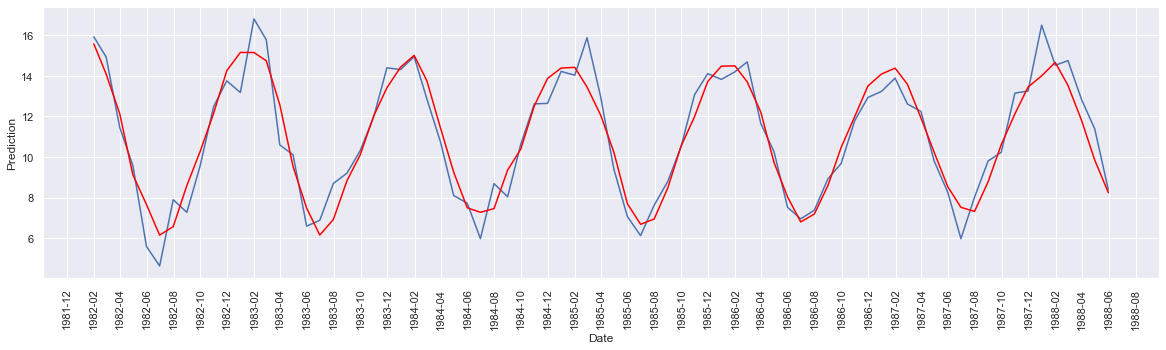

In [623]:
# Plot the results on the trainng dataset
fig, ax = plt.subplots(figsize=(20, 5))
g = sb.lineplot(data=train_results, x='Date', y='NextTemp', ax=ax)
g = sb.lineplot(data=train_results, x='Date', y='Prediction', ax=ax, color='red')
plt.xticks(rotation=90)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

The results look pretty good, but it does appear there is a little overprediction for July and underprediction for March. Let's add those columns in and see if we can do it better. We might also choose to add in any months that represents peaks or troughs.

In [624]:
# Get the month column list but sans July and March
month_cols.remove('July')
month_cols.remove('March')

# Create a new train set with July and March added in
Xf_train = df_train.drop(columns=['Date', 'NextTemp'] + lag_list + month_cols + ['SixMonthMovingAvg'])

Now let's rebuild the model and check the score.

In [625]:
# Rescore a model on the new Xf set
best_regressor = ridge_hyper_search(X=Xf_train, alphas=alphas, verbosity=0)
best_regressor.best_score_

-0.9648962091962586

The score is ever so sightly better. We'll keep the columns even though it's not a huge improvement. However, it's possible the model could be made better by simply being more parsimonious. Let's see if all of our lag columns really are that helpful by testing out keeping a different lag length each time. We'll also, by arbitrary hunch, try out testing with just a few lags and then the 12th lag for seasonality.

In [626]:
# Get our list of deltas
deltas_list = ['DeltaTempLag{}'.format(lag + 1) for lag in range(12)]

# Create some empty lists to append to
rmses = []
lags_dropped = []

# Iterate over length of lagged deltas
for maxlag in range(1, 13):
    
    # Create a list of lags used given that the max lag
    lags_used = ['DeltaTempLag{}'.format(lag + 1) for lag in range(maxlag)]
    
    # But really we want the list of lags to drop, so create that
    remaining_lags = list(set(deltas_list) - set(lags_used))
    lags_dropped.append(remaining_lags)
    
    # Rescore a model on the new training set and append
    best_regressor = ridge_hyper_search(X=Xf_train.drop(columns=remaining_lags), alphas=alphas, verbosity=0)
    rmse = best_regressor.best_score_
    rmses.append(rmse)
    
# Create our arbitrary hunch where we keep a few lags and then the seasonal lag
hunch_lags = ['DeltaTempLag1', 'DeltaTempLag2', 'DeltaTempLag3', 'DeltaTempLag12']
hunch_drops = list(set(deltas_list) - set(hunch_lags))
lags_dropped.append(np.NaN)
best_regressor = ridge_hyper_search(X=Xf_train.drop(columns=hunch_drops), alphas=alphas, verbosity=0)
rmse = best_regressor.best_score_
rmses.append(rmse)

# Now run through the results to see what we get
for drops, rmse in zip(lags_dropped, rmses):
    
    if drops != drops: # NaN check
        print('Lags Dropped: {}, RMSE: {}'.format('Hunch', rmse))
    else:
        print('Lags Dropped: {}, RMSE: {}'.format(len(drops), rmse))

Lags Dropped: 11, RMSE: -0.9131635637062685
Lags Dropped: 10, RMSE: -0.8612337768922369
Lags Dropped: 9, RMSE: -0.9096635954265627
Lags Dropped: 8, RMSE: -0.937086391084701
Lags Dropped: 7, RMSE: -0.9312150662822916
Lags Dropped: 6, RMSE: -0.9302182561157443
Lags Dropped: 5, RMSE: -0.9261294698857047
Lags Dropped: 4, RMSE: -0.9175388167727266
Lags Dropped: 3, RMSE: -0.926667654562128
Lags Dropped: 2, RMSE: -0.9188901080850844
Lags Dropped: 1, RMSE: -0.9236455056003502
Lags Dropped: 0, RMSE: -0.9648962091962586
Lags Dropped: Hunch, RMSE: -0.9252752038954245


These are quite interesting results. The implication is that realistically we only need the first couple of lags to get a better score. This is also helpful in that it means we don't have to drop as many earlier records from the training set (due to missing values from lags).

Since we had to drop those previously, let's rebuild our data to get it back.

In [627]:
# Lags to drop
drop_lags = ['DeltaTempLag{}'.format(lag + 1) for lag in range(2, 12)]
drop_lags

['DeltaTempLag3',
 'DeltaTempLag4',
 'DeltaTempLag5',
 'DeltaTempLag6',
 'DeltaTempLag7',
 'DeltaTempLag8',
 'DeltaTempLag9',
 'DeltaTempLag10',
 'DeltaTempLag11',
 'DeltaTempLag12']

In [628]:
# Drop those columns from the original df, we're done with them
df.drop(columns=drop_lags, inplace=True)

# Rebuild the training set
df_train = df[df.Date < '1988-06-30'].copy()
df_train.dropna(inplace=True) # There will still be some missing initial lags

# Rebuild our Xf and y
y_train = df_train.NextTemp
Xf_train = df_train.drop(columns=['Date', 'NextTemp'] + lag_list + month_cols + ['SixMonthMovingAvg'])

# Double check the results
Xf_train.columns

Index(['Temp', 'July', 'March', 'SeasonalNext', 'DeltaTempLag1',
       'DeltaTempLag2', 'TempSkew'],
      dtype='object')

In [629]:
# Score the new model
best_regressor = ridge_hyper_search(X=Xf_train, alphas=alphas, verbosity=0)
rmse = best_regressor.best_score_
rmse

-0.8612337768922369

Much better. Let's plot it just to be sure!

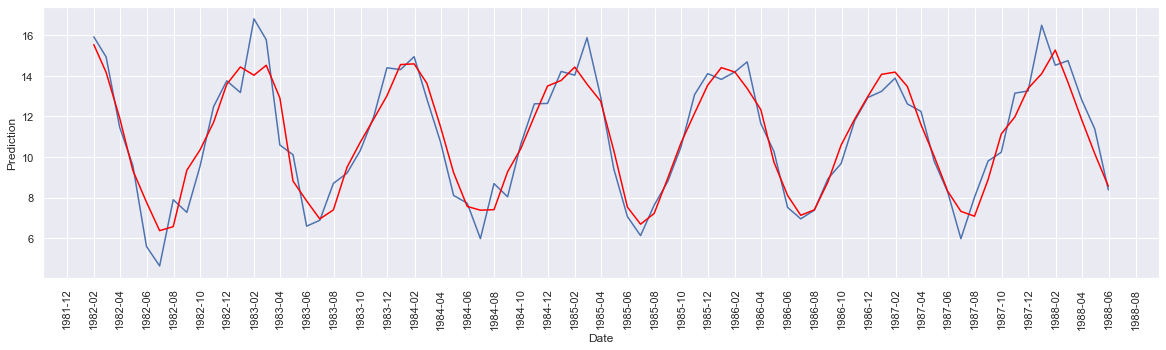

In [630]:
# Create our convenience results df again
train_results = df_train.copy()[['Date', 'Temp', 'NextTemp']]
train_results['Prediction'] = best_regressor.predict(Xf_train)

# Plot the results on the training data
fig, ax = plt.subplots(figsize=(20, 5))
g = sb.lineplot(data=train_results, x='Date', y='NextTemp', ax=ax)
g = sb.lineplot(data=train_results, x='Date', y='Prediction', ax=ax, color='red')
plt.xticks(rotation=90)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

Let's move on to evaluation.

### Test Set Evaluation
<a id='ML_Test_Set_Evaluation'></a>

We'll need to first rebuild our test X feature set in the same way as the train set.

In [631]:
# Rebuilt the test set (we have less lags now)
df_test = df[df.Date >= '1988-06-30'].copy()
df_test.dropna(inplace=True)

# Create the matching featureset
Xf_test = df_test.drop(columns=['Date', 'NextTemp'] + lag_list + month_cols + ['SixMonthMovingAvg'])

# Create a keeper dataset of the test set with predictions
test_results_regression = df_test[['Date', 'Temp', 'NextTemp']].copy()
test_results_regression['Prediction'] = best_regressor.predict(Xf_test)

Now let's store and dispaly the results.

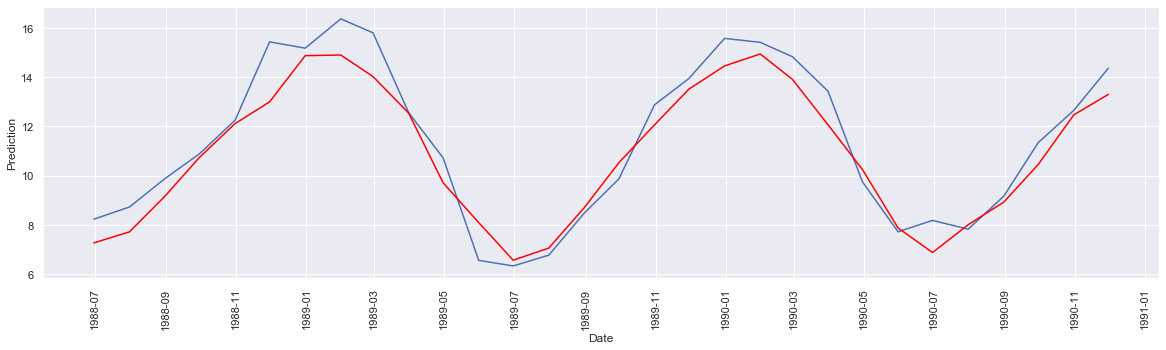

In [632]:
# Plot the results
fig, ax = plt.subplots(figsize=(20, 5))
g = sb.lineplot(data=test_results_regression, x='Date', y='NextTemp', ax=ax)
g = sb.lineplot(data=test_results_regression, x='Date', y='Prediction', ax=ax, color='red')
plt.xticks(rotation=90)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

In [633]:
# Get the RMSE
rmse_regression = mean_squared_error(test_results_regression.NextTemp, test_results_regression.Prediction, squared=False)
print(rmse_regression)

0.9470100202943346


Not too bad! Just about a degree off on average.

### Cleanup

Let's clean up our memory some and reset our train and test sets since we dropped some values earlier.

In [634]:
# Clean up the memory
del Xall_test
del Xall_train
del Xb_train
del Xc_train
del Xd_train
del Xe_train

# Reset our train/test sets since we dropped some initial values earlier
df_train = df[df.Date < '1988-06-30'].copy()
df_test = df[df.Date >= '1988-06-30'].copy()

## Time-Series Framework
<a id='Time-Series_Framework'></a>

We have a univariate series with clear seasonal behavior so, in this case, a SARIMA is a good go-to. For that, perhaps the best Python implementation currently lives in StatsModels. It's worth noting though that this implementation isn't very robust speed-wise. So while we'll plan to grid-search the hyperparemters for this dataset, we'd likely have to be a bit more intentional for a larger one and apply more expertise to get reasonable hyper values.

### SARIMA Model Selection
<a id='T_Sarima_Model_Selection'></a>

Data preparation when using ARIMA-like methodology however is quite different from the ML take as the input is typically univariate (typically as you *could* run a SARIMA(X) implementation). Accounting for lags, seasonality, trend values, and whatnot are handled by the algorithm itself via its [various hyperparameters](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html). Ultimately, the SARMIA implementation in StatsModels expects a series as an input with a defined date index of a known frequency/period. We set that up below.

In [39]:
# Create our train and test pandas series, explicitly defining the period/frequency
train_series = df_train[['Temp', 'Date']].set_index('Date').Temp
train_series.index = train_series.index.to_period('M')
test_series = df_test[['Temp', 'Date']].set_index('Date').Temp
test_series.index = test_series.index.to_period('M')

The main challenge with fitting our SARIMA model will be picking the right hyperparameters. SARIMA fitting can be computationally expensive, so verifying that we only need to check a "few" will be helpful. To find those parameters (the p, q, d, P, D, Q) of the model, it can be helpful to look at ACF and PACF plots. The ACF plot below is essentially the same as that already plotted in the ML steps above, but using the Statsmodels version. The P(artial)ACF plot shows a similar interrogation but accounts for correlations due to prior lags. For instance if lag 3 shows a spike in the ACF, but that information can be accounted for by lags 1 - 2, the PACF plot for lag 3 will be much smaller.

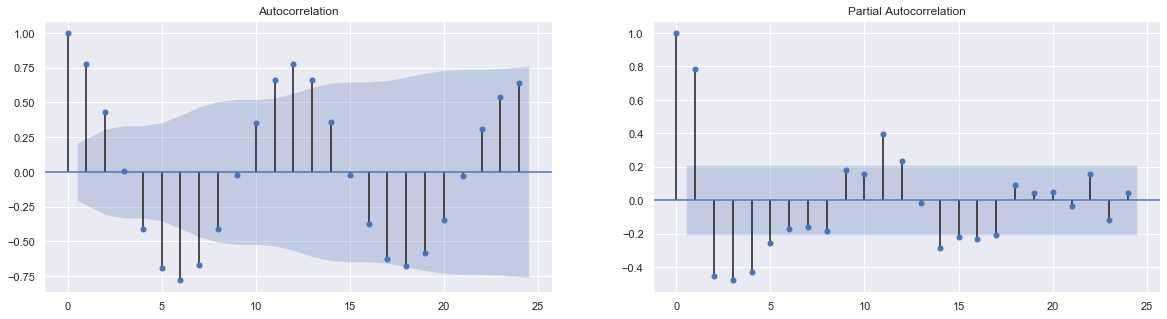

In [40]:
# Plot the ACF and PACF for our train series
fig, ax = plt.subplots(1,2,figsize=(20,5))
sm.graphics.tsa.plot_acf(train_series, lags=24, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_series, lags=24, ax=ax[1])
plt.show()

The seasonality pattern here is obvious and should be removed to see what autocorrelations are left over. Also, generally before using the ACF and PACF plots, the series is made stationary. In our case, we've already done decomposition analysis and have seen that a yearly season cycle is strong, but there's not an obvious trend. It's likely we can get a quasi-stationary series just from a simple seasonal differencing.

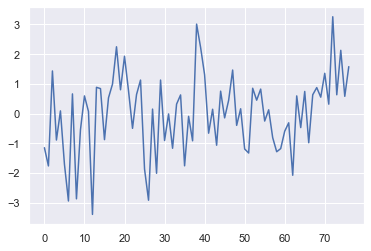

In [41]:
# Create the deseasoned series
train_series_deseasoned = (train_series - train_series.shift(12))
train_series_deseasoned.dropna(inplace=True)

# Plot that series
plt.plot(train_series_deseasoned.values)
plt.show()

The series above does seem to have lost most of it's structure with no remaining obvious time-driven factors. There is more investigation we could do, but since we're grid-searching the SARIMA hypers, arguably we need not be extremely precise. A further argument would be that this series would pass an Augmented Dickey-Fuller for stationarity. So we'll try that for at least curiosity via the Statsmodels implementation. Slicing at 1 on the results yields the p-value for the test.

In [42]:
# Statsmodels AD-Fuller test
# Printed result is a p-value
adfuller(train_series_deseasoned)[1]

0.0029269471597496684

Given that p-value, we can reject the null hypothesis (not stationary) with 95% confidence. With our series set up then, let's look at the ACF and PACF again. 

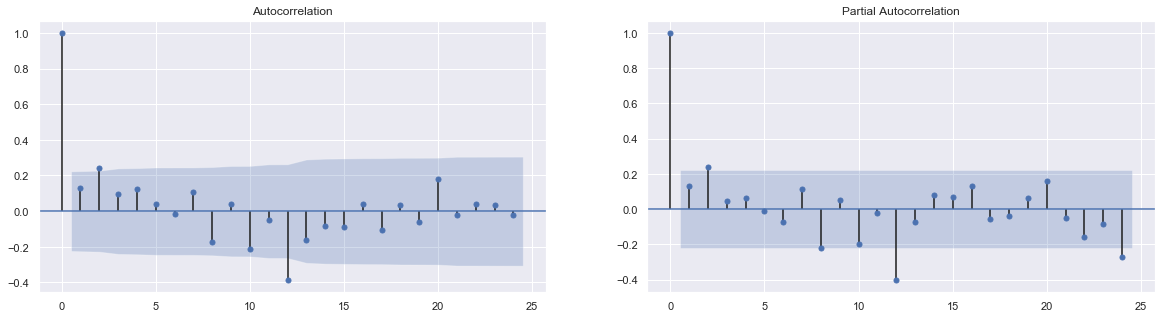

In [43]:
# ACF and PACF plots on the deseasoned series
fig, ax = plt.subplots(1,2,figsize=(20,5))
sm.graphics.tsa.plot_acf(train_series_deseasoned, lags=24, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_series_deseasoned, lags=24, ax=ax[1])
plt.show()

There's a lot that could be investgated here ([here is a nice guide](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html) for using these plots for picking the right hypers), but luckily it appears clear that deseasoning removed most of the significant autocorrelations (and a reminder that we will grid search anyways). What is interesting is the remaining peaks as 12 and 24 lags. This might suggest a need for a 1 or 2 term in the AR or MA seasonal components. However we might reasonably expect the non-seasonal ARIMA components to have little play in this model.


Regarding the grid-search, we'll take a naive approach and create *all* possible lower order combinations to hopefully account for any lack of expertise in interpretting the above plots. Some might be garbage or even throw an error, but we'll run the just in case.

In a larger dataset, we'd want to spend more time more explicitly defining reasonable parameters to reduce computation time, but since the data here is fairly small, we'll take anything reasonable and handle errors with try/except statements in our search.

In order to do so, the below helper function is made to create a list of dictionaries. Each dictionary represents a hyperparameter combination that will be fed to the SARIMA model in the search.

In [44]:
# Function to create hyperparameter combinations
# Arguments expect a list of possible options for each hyperparameter
def sarimax_hypers(p_options, d_options, q_options,
                   P_options, Q_options, D_options, m_options,
                   trend_options, diff_options,
                   stationarity_options, invertibility_options):
    
    # Create an empty list to append hyperparemter dicts to
    hyper_combos = []
    
    # Create all possible options
    for p in p_options:
        for d in d_options:
            for q in q_options:
                for P in P_options:
                    for D in D_options:
                        for Q in Q_options:
                            for m in m_options:
                                for trend in trend_options:
                                    for diff in diff_options:
                                        for stat in stationarity_options:
                                            for invert in invertibility_options:
                                                
                                                # Create the dictionary
                                                combo_dict = {'order': (p, q, d),
                                                             'seasonal_order': (P, Q, D, m),
                                                             'trend': trend,
                                                             'diff': diff,
                                                             'stat': stat,
                                                             'invert': invert}
                                                
                                                # Append the dictionary to the list
                                                hyper_combos.append(combo_dict)
                                                
    # Return the list of dicts
    return hyper_combos

# Create the actual list we are interested in
hyper_combos = sarimax_hypers([0, 1, 2], [0, 1], [0, 1, 2],
                              [0, 1, 2, 3], [0, 1, 2], [0, 1, 2, 3], [12],
                              ['n','c', 't'], [False],
                              [True], [True])

# Double check the length of said options
len(hyper_combos)

2592

Since ARIMA-like models are often used to recursively predict multiple values (by using one prediction as in the input data for another), and since ARIMA-like models are often retrained before making new predictions, the statsmodels implementation won't play well with a typical SciKitLearn gridsearch. As such, we set up our own.

The general logic is:

    1) Use Scitkit's TimeSeriesSplit() to create training and testing folds
    2) Plan to store the RMSE value and hypers used for each loop
    3) Plan for possibly bad hyper combos. Just uses numpy's NAN for their RMSE results
    4) Train on the train fold and get the RMSE from the test fold:
        * For the test fold, iterate across each record
        * On each iteration, append the new observation to the model (needed for StatsModels implementation)
        * Get the prediction, add it to a predictions list, and eventually score
    5) Finally construct a pandas dataframe with what we've stored so we can check the results
    
This make-shift grid-search is then implemented below. We'll drop the number of splits both in order to have more data, run faster, and to enable longer look-backs that may require that data (due to given hyperparameter combos).

In [45]:
# Grid search across all hyperparamter combinations

# Create a generator that yields the indices of our train and test folds
series_split = list(TimeSeriesSplit(n_splits=2).split(train_series)) # Make it a list so we can use it multiple times

# Create some empty lists to append to
avg_rmse_list = []
std_rmse_list = []
order_list = []
sorder_list = []
trend_list = []
diff_list = []
stationarity_list = []
invertibility_list = []



# Grid search over all possible hyperparemeter combinations
for hyper in tqdm(hyper_combos):

    # Grab the current hypers and append them to the lists
    # These will be used to construct a dataframe later to check the results
    order = hyper['order']
    seasonal_order = hyper['seasonal_order']
    trend = hyper['trend']
    diff = hyper['diff']
    stationarity = hyper['stat']
    invertibility = hyper['invert']
    order_list.append(order)
    sorder_list.append(seasonal_order)
    trend_list.append(trend)
    diff_list.append(diff)
    stationarity_list.append(stationarity)
    invertibility_list.append(invertibility)

    # Create a running rmse list to append to
    rmse_list = []

    
    
    # Loop through each fold set
    for train_idcs, test_idcs in series_split:

        # Create an empty prediction list to append to
        predictions = []

        # Create the folds
        train_fold = train_series[train_idcs]
        test_fold = train_series[test_idcs]

        
        
        # Run some error handling for bad hyper combos
        # If a combo results in a bad result, append np.NAN
        try:

            # Ignore all the warnings, we're expecting them and it's too noisy otherwise
            with catch_warnings():
                filterwarnings('ignore')

                # Fit the model on the training fold
                model_instance = sm.tsa.statespace.SARIMAX(train_fold,
                                                           order=order, seasonal_order=seasonal_order,
                                                           trend=trend, simple_differencing=diff,
                                                           enforce_stationarity=stationarity,
                                                           enforce_invertibility=invertibility)
                # In the fitting, use some methods to make it run a bit faster
                model_fitted = model_instance.fit(disp=False, cov_type='none', maxiter=200)

                # Create the initial prediction
                pred = model_fitted.forecast(steps=1)[0] # Slice so we just get the forecast value only
                predictions.append(pred)



                # Now loop through the test set, adding observations individually, and getting the next prediction
                for i in range(len(test_fold) - 1): # -1 as the final prediction we wouldn't have an actual for

                    # Get the next row
                    next_row = test_fold.iloc[i:i+1] # Returns single row but in series form (which statsmodels expects)

                    # Append the row to the model
                    model_fitted = model_fitted.extend(next_row) # alternatively .append(next_row, refit=False)

                    # Get the new prediction
                    pred = model_fitted.forecast(steps=1)[0] # Slice so we just get the forecast value only
                    predictions.append(pred)



                # Calculate and append the error
                rmse = mean_squared_error(predictions, test_fold.values, squared=False)
                rmse_list.append(rmse)

                
                
        except:

            # If error, just let the rmse values be NAN
            rmse_list.append(np.NaN)

            

    # Now get the average and stdv error for this hyperparam combo and append to the list
    avg_rmse = np.mean(rmse_list)
    avg_rmse_list.append(avg_rmse)
    std_rmse = np.std(rmse_list)
    std_rmse_list.append(std_rmse)

      

# Once done with the loop, create a pandas dataframe to look at the results
grid_search_df = pd.DataFrame(data={'Avg_RMSE': avg_rmse_list,
                                    'Std_RMSE': std_rmse_list,
                                    'Order': order_list,
                                    'Seasonal_Order': sorder_list,
                                    'Trend': trend_list,
                                    'Simple_Differencing': diff_list,
                                    'Enforce_Stationarity': stationarity_list,
                                    'Enforce_Invertibility': invertibility_list})

# Show the results, get rid of the errors
grid_search_df.sort_values(by='Avg_RMSE').dropna()

100%|████████████████████████████████████████████████████████████████████████████| 2592/2592 [2:10:18<00:00,  3.02s/it]


,Avg_RMSE,Std_RMSE,Order,Seasonal_Order,Trend,Simple_Differencing,Enforce_Stationarity,Enforce_Invertibility
1820,9.843894e-01,4.854890e-02,"(2, 0, 0)","(2, 0, 2, 12)",t,False,True,True
2252,1.012085e+00,4.219429e-02,"(2, 0, 1)","(2, 0, 2, 12)",t,False,True,True
956,1.015891e+00,9.305249e-04,"(1, 0, 0)","(2, 0, 2, 12)",t,False,True,True
1407,1.017328e+00,1.721922e-01,"(1, 0, 1)","(3, 1, 0, 12)",n,False,True,True
1380,1.017887e+00,1.696933e-01,"(1, 0, 1)","(2, 1, 1, 12)",n,False,True,True
...,...,...,...,...,...,...,...,...
764,6.672053e+05,6.672031e+05,"(0, 2, 1)","(1, 2, 0, 12)",t,False,True,True
728,6.672054e+05,6.672031e+05,"(0, 2, 1)","(0, 2, 0, 12)",t,False,True,True
1415,1.444482e+09,1.444482e+09,"(1, 0, 1)","(3, 0, 1, 12)",t,False,True,True
1646,1.631469e+11,1.631469e+11,"(1, 2, 1)","(1, 2, 2, 12)",t,False,True,True


The resulting best scoring model is right in line with expectations from the PACF plots. Let's formalize that now built on the train set.

In [51]:
# Fit the model on the training series
model_instance = sm.tsa.statespace.SARIMAX(train_series,
                                           order=(2, 0, 0), seasonal_order=(2, 0, 2, 12),
                                           trend='n', simple_differencing=False,
                                           enforce_stationarity=True,
                                           enforce_invertibility=True)
# Fit the model
model_fitted = model_instance.fit(disp=False, maxiter=200)

# Note the given error doesn't mean that the final estimations are 0, it's just a warm start kind of thing

C:\Users\Josh\Anaconda3\envs\PyCurrDA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Josh\Anaconda3\envs\PyCurrDA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


### Test Set Evaluation
<a id='T_Test_Set_Evaluation'></a>

Now we'll use the same logic used in the grid search to step through the test set (without refitting), appending new observations, and then getting the score.

In [52]:
# Create an empty prediction list to append to
predictions = []

# Create the initial prediction
pred = model_fitted.forecast(steps=1)[0] # Slice so we just get the forecast value only
predictions.append(pred)

# Now loop through the test set, adding observations individually, and getting the next prediction
for i in range(len(test_series) - 1): # -1 as the final prediction we wouldn't have an actual for

    # Get the next row
    next_row = test_series.iloc[i:i+1] # Returns single row but in series form (which statsmodels expects)

    # Append the row to the model
    model_fitted = model_fitted.extend(next_row) # alternatively .append(next_row, refit=False)

    # Get the new prediction
    pred = model_fitted.forecast(steps=1)[0] # Slice so we just get the forecast value only
    predictions.append(pred)

# Create a df for the results
test_results_sarima = pd.DataFrame(data=test_series).copy()
test_results_sarima.index = test_results_sarima.index.to_timestamp()
test_results_sarima['Prediction'] = predictions
test_results_sarima.reset_index(inplace=True)
test_results_sarima.head()

,Date,Temp,Prediction
0,1988-06-01,8.386667,8.709931
1,1988-07-01,8.232258,7.578625
2,1988-08-01,8.725806,9.145289
3,1988-09-01,9.883333,10.423012
4,1988-10-01,10.890323,10.773916


Just like last time, let's calculate the RMSE and plot the results.

In [53]:
# Calculate and print the error
rmse_sarima = mean_squared_error(test_results_sarima.Prediction, test_results_sarima.Temp, squared=False)
print(rmse_sarima)

0.8323334829281888


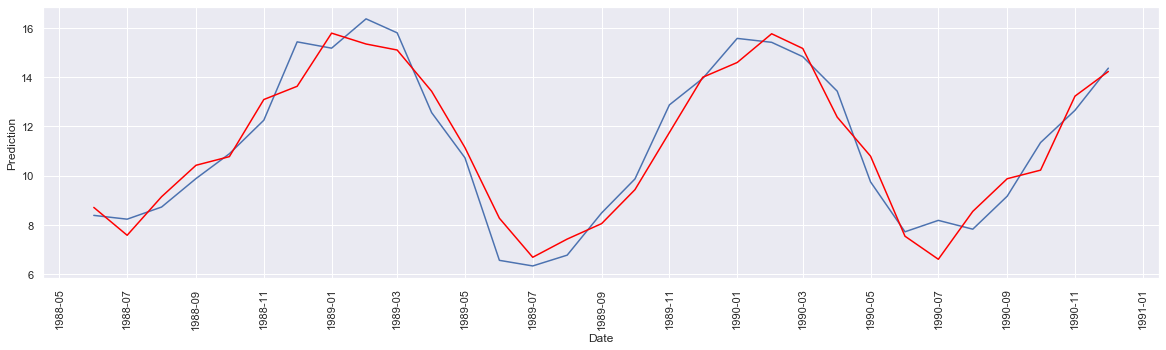

In [54]:
# Plot the results
fig, ax = plt.subplots(figsize=(20, 5))
g = sb.lineplot(data=test_results_sarima, x='Date', y='Temp', ax=ax)
g = sb.lineplot(data=test_results_sarima, x='Date', y='Prediction', ax=ax, color='red')
plt.xticks(rotation=90)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

Note if you squint at the axis alignment for regression vs SARIMA here you'll note a shift. This is as expected due to how SARIMA doesn't have a "label" or target feature column. The prediction is always made via information for the last record and the comparison results conveniently end up being on the same date. This is just formatting and could be rearranged, but for comparison, note how in regression we have a "NextTemp" column.

Regardless, results look good!

## Conclusion
<a id='Conclusion'></a>

Finally time to compare the results. Let's create a convenience df for plotting where the SARIMA and regression results are alligned right for comparison.

In [635]:
# Create a final df for comparison of results
df_final = test_results_sarima.copy()
df_final.rename(columns = {'Prediction':'SARIMA_Prediction'}, inplace=True)

# We have to to reorganize the regression predictions a little to fit right
# Since SARIMA builds in a successive fashion, it will have a prediction from the last record of the training set
# The regression set won't, so we pad it with a NaN and drop the NaN records
regression_predictions = [np.NaN] + list(test_results_regression.Prediction.values)
df_final['Regression_Prediction'] = regression_predictions
df_final = df_final.dropna()

Finally, plot the results. Not using Seaborn here is a little easier just to get the multiple lines going on.

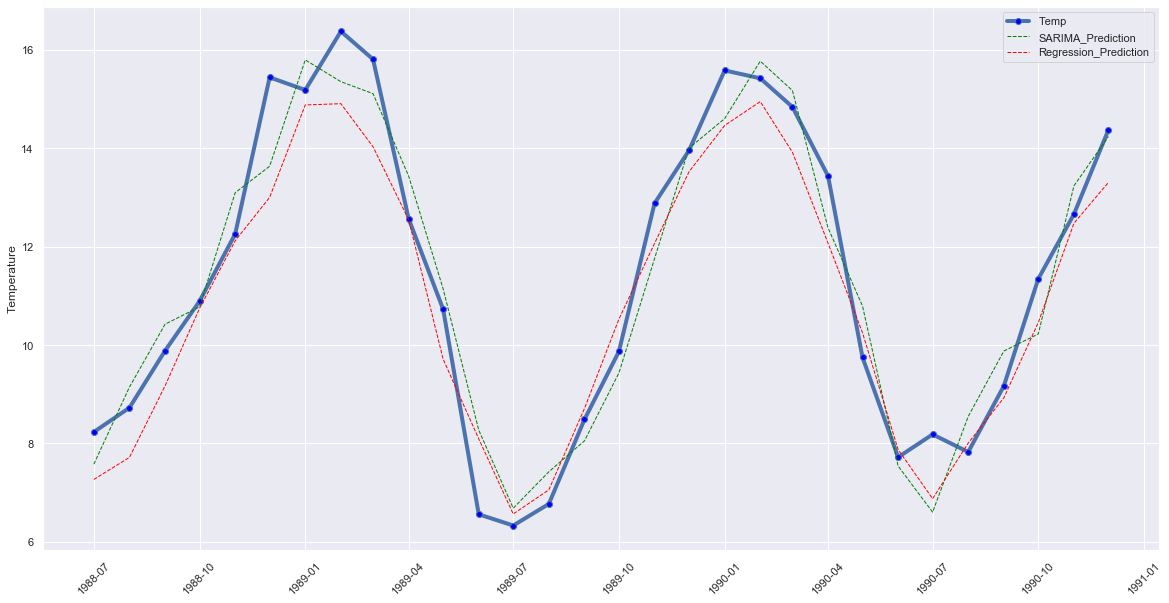

In [636]:
# Set the plots
plt.figure(figsize=(20, 10))
plt.plot('Date', 'Temp', data=df_final, marker='o', markerfacecolor='blue', linewidth=4)
plt.plot('Date', 'SARIMA_Prediction', data=df_final, marker='', color='green', linewidth=1, linestyle='dashed')
plt.plot('Date', 'Regression_Prediction', data=df_final, marker='', color='red', linewidth=1, linestyle='dashed')

# Clean the axis
plt.xticks(rotation=45)
plt.ylabel('Temperature')

# show legend
plt.legend()

# show graph
plt.show();

And the winner (accordingly to RMSE criterion!) is...

In [637]:
# Pick the winner!
if rmse_regression < rmse_sarima:
    win = 'Regression'
    perc = ((rmse_sarima - rmse_regression)/ rmse_sarima) * 100
else:
    win = 'SARIMA'
    perc = ((rmse_regression - rmse_sarima)/ rmse_regression) * 100
    
# Print the results
print('Regression RMSE is: {}'.format(rmse_regression))
print('SARIMA RMSE is: {}'.format(rmse_sarima))
print('Winner is {} by {}%!'.format(win, round(perc, 2)))

Regression RMSE is: 0.9470100202943346
SARIMA RMSE is: 0.8323334829281888
Winner is SARIMA by 12.11%!


According to conventional wisdom, the time-series framework model of SARIMA does pan out better than logistic regression. One could argue however:

* The results are contingent on the skill of the user
* Different test metrics (like MAPE or MAE) might produce different resuts
* This was an easy dataset, the difference might be more extreme for other data

Which I would agree! However, it does seem clear to me that while the conventional wisdom to use a time-series approach does stand, it's *not* true that typical ML models fall on their face for time-series data. Arguably with a little more clever feature generation, the linear regression model might have caught up or superceded the SARIMA one. My personal take at the end of this: **It's worth knowing and trying both approaches OR (personal opinon), in a time crunch, using the one you are more familiar with is likely fine!**

That said, I did notice some pretty clear-cut pros and cons while doing it:

* ***Regression/ML Framework***
 * Pros
    * Familiarity. I'd argue that most in this "space" of modelling have more familiarity with regression models than (S)ARIMA(X), though I could be wrong. If not, that's me at least.
    * Flexibility. Feature engineering in regression is clear and simple and allows you do to things like including noncontinuous lags (i.e. lags 1 - 12, but skip 6 - 11) that time-series would not. Additionally things like interaction effects could be more cleanly modelled. However one could do a SARIMA(X) to include exogenous variables, though the interpretation might be off.
    * Optimization. Most regression libraries by now are blazing fast and allow for quick performance searches across a lot of parameters. This can result in requiring less technical knowledge by following a sense of "optimize it to heck" until you get a good result.
    * Library friendly. There are tons of packages built up and around a typical regression or ML implementation. Being able to play well with libraries like SciKitLearn is a plus.
    * Direct nth step prediction. Regression and ML frameworks can have targets for the nth-step ahead in a much more (my opinion) clean way. That nth step is simply the target and the values known at that time can be the input. Full stop. Time-series approaches however require that the time index be built incrementally, so to get, say, 6 steps ahead, they need to recursively walk those steps to get there.
  * Cons
    * ***The possible reduced prediction power of course.***
    * *You* have to do the work in feature engineering. Arguably then there is a lot of requirements placed on the skill of the user. Not to mention, this can take some time and technical dept.
    * If you want to recursively generate n-steps ahead for a forecast, you have to do all of that ETL to make it happen. Depending on the regressors you've set up, that may or may not be a tedious process.
   
   
* ***SARIMA/Time-series Framework***
 * Pros
    * ***The expected better performance of course***.
    * Conventional wisdom. If you have a time-series problem, others are likely expecting this approach.
    * Recursive forecast simplicity. At least in the statsmodels implementation, generating multiple forecast values by recursively using the output of one prediction as input for the next is as painless as it could be. Since the input to the model api is univariate, you don't need to ETL those next steps like you would for regression/ML.
 * Cons
    * At least in the Python Statsmodels integration, the speed of fitting a SARIMA model is terribly slow compared to regression. This might make grid searches for larger datasets simply untennable and thereby require more expertise in identifying model hyperparameters.
    * Validation is darn tricky. You can not just provide a SARIMA model with a test array and get the predictions accordingly (to the best of my knowledge!). You must walk across the test step, extending the range of the model's input one-at-a-time.
    * The knowledge required to build a great time-series model is in some ways a completely different paradigm than that of a typical ML model (stationarity, differencing, PACF plots, etc etc). Perhaps this is not a true con, but some argument might be made.

As always, there's likely much more to be done/listed but I write these for me and hopefully have given both cases a fair shake!